In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw
import pickle
import matplotlib as mpl
import cmocean
from scipy import stats as spst
import scipy.optimize as scopt

%matplotlib inline

In [2]:
dstart=dt.datetime(2015,1,1)
dend=dt.datetime(2018,1,1)

In [3]:
# conversion factors
r_uE_W=1/0.2174 # (uE/m2/s) / (W/m2)
r_PAR_I=0.44 # as in model use PAR = 44% of surface irradiance

In [4]:
basedir='/data/eolson/results/MEOPAR/PARcalcs/'
dbname='DFO_CTD_withModelPAR.sqlite'
datelims=()
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)


In [5]:
session.query(ObsTBL.PAR_Reference_units).distinct().all()

[(None), ('uE/m^2/sec')]

In [6]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                StationTBL.Lat,StationTBL.Lon,ObsTBL.PAR_Reference.label('PARRef')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR_Reference>=0,
                                            StationTBL.StartYear>=dstart.year,
                                            or_(StationTBL.StartYear>dstart.year,StationTBL.StartMonth>=dstart.month),
                                            StationTBL.StartYear<=dend.year,
                                            or_(StationTBL.StartYear<dend.year,StationTBL.StartMonth<=dend.month))
                                                          ).distinct()


In [7]:
df1=pd.DataFrame(qry.all())

In [8]:
len(df1)

39858

In [9]:
df1['dtUTC']=[dt.datetime(int(y),int(m),int(d))+dt.timedelta(hours=h) \
              for y,m,d,h in zip(df1['Year'],df1['Month'],df1['Day'],df1['Hour'])]

In [10]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

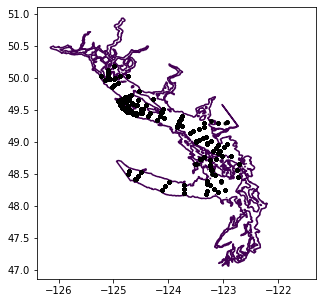

In [11]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(df1['Lon'],df1['Lat'],'k.')
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))

In [12]:
df1.head()

,Year,Month,Day,Hour,Lat,Lon,PARRef,dtUTC
0,2016.0,4.0,21.0,22.975556,48.651833,-123.511,2214.9,2016-04-21 22:58:32
1,2016.0,4.0,21.0,22.975556,48.651833,-123.511,2213.1,2016-04-21 22:58:32
2,2016.0,4.0,21.0,22.975556,48.651833,-123.511,2214.5,2016-04-21 22:58:32
3,2016.0,4.0,21.0,22.975556,48.651833,-123.511,2213.6,2016-04-21 22:58:32
4,2016.0,4.0,21.0,22.975556,48.651833,-123.511,2213.4,2016-04-21 22:58:32


In [13]:
df1.tail()

,Year,Month,Day,Hour,Lat,Lon,PARRef,dtUTC
39853,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,12.3,2017-10-09 08:14:20
39854,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,10.8,2017-10-09 08:14:20
39855,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,14.0,2017-10-09 08:14:20
39856,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,14.1,2017-10-09 08:14:20
39857,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,14.2,2017-10-09 08:14:20


In [14]:
df2=df1.head(120)

In [15]:
flen=1
namfmt='wind'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'solar':'ops',}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ops':1,}
PATH='/results/forcing/atmospheric/GEM2.5/operational/'

In [16]:
data=pickle.load(open('loadPARCTDops.pkl','rb'))

In [17]:
data['mod_solar']=data['mod_solar']*r_PAR_I*r_uE_W

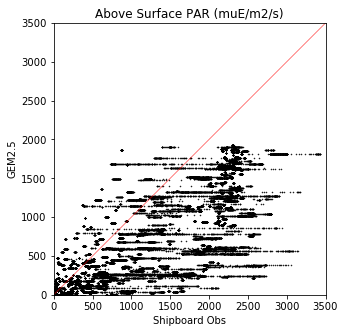

In [18]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(data['PARRef'],data['mod_solar'],'k.',ms=1)
ax.set_xlabel('Shipboard Obs')
ax.set_ylabel('GEM2.5')
ax.set_title('Above Surface PAR (muE/m2/s)')
ax.set_aspect(1)
ax.set_xlim(0,3500)
ax.set_ylim(0,3500)
ax.plot((0,3500),(0,3500),'r-',lw=.5)

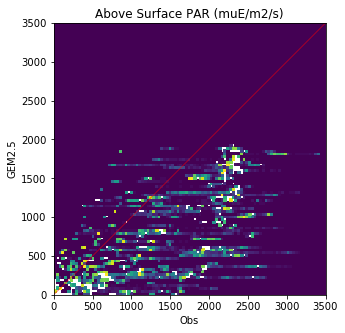

In [19]:
ii=(data['mod_solar']>=0)&(data['PARRef']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_solar']].values
xx=data.loc[ii,['PARRef']].values
ax.hist2d(xx[:,0],yy[:,0],cmin=0,cmax=50,bins=np.linspace(0,3500,100));
ax.set_xlabel('Obs')
ax.set_ylabel('GEM2.5')
ax.set_title('Above Surface PAR (muE/m2/s)')
ax.set_aspect(1)
ax.set_xlim(0,3500)
ax.set_ylim(0,3500)
ax.plot((0,3500),(0,3500),'r-',lw=.5)

Text(0.5, 1.0, 'Reference PAR Direct Comparison')

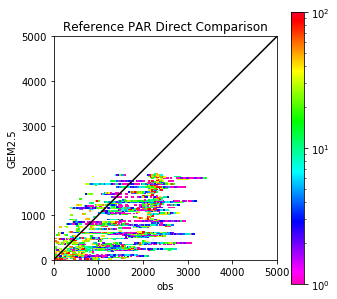

In [20]:
ii=(data['mod_solar']>=0)&(data['PARRef']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_solar']].values
xx=data.loc[ii,['PARRef']].values
_,_,_,m=ax.hist2d(xx[:,0],yy[:,0],bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r,vmin=1,vmax=10**2);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,5000)
ax.set_ylim(0,5000)
ax.set_aspect(1)
ax.plot((0,5000),(0,5000),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('GEM2.5')
ax.set_title('Reference PAR Direct Comparison')

Text(0.5, 1.0, 'Reference PAR Direct Comparison (µEm$^{-2}$s$^{-1}$)')

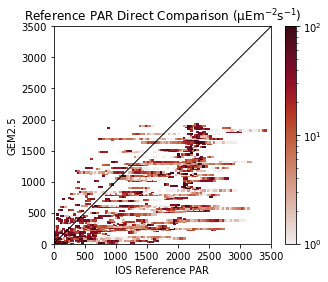

In [21]:
ii=(data['mod_solar']>=0)&(data['PARRef']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,4))
yy=data.loc[ii,['mod_solar']].values
xx=data.loc[ii,['PARRef']].values
_,_,_,m=ax.hist2d(xx[:,0],yy[:,0],bins=100,norm=mpl.colors.LogNorm(), cmap=cmocean.cm.amp,vmin=1,vmax=10**2);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,3500)
ax.set_ylim(0,3500)
ax.set_aspect(1)
ax.plot((0,5000),(0,5000),'k-',lw=1)
ax.set_ylabel('GEM2.5')
ax.set_xlabel('IOS Reference PAR')
ax.set_title('Reference PAR Direct Comparison (µEm$^{-2}$s$^{-1}$)')

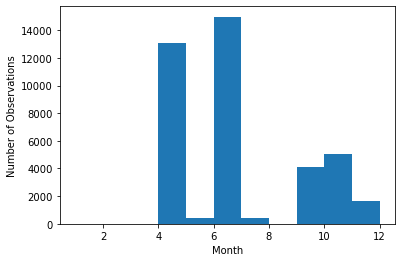

In [22]:
plt.hist(data['Month'],np.arange(1,13))
plt.xlabel('Month')
plt.ylabel('Number of Observations');

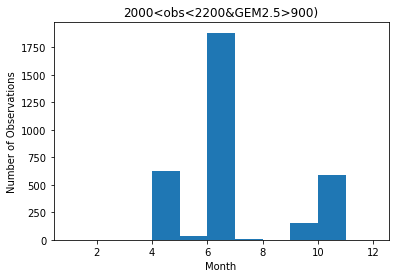

In [23]:
plt.hist(data.loc[(data.PARRef>2000)&(data.PARRef<2200)&(data.mod_solar>900),['Month']].values,np.arange(1,13))
plt.xlabel('Month')
plt.ylabel('Number of Observations')
plt.title('2000<obs<2200&GEM2.5>900)');

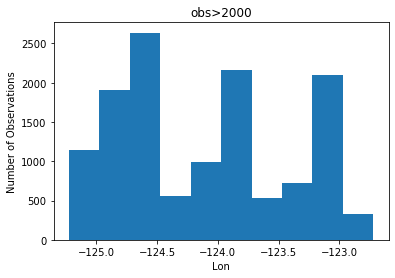

In [24]:
plt.hist(data.loc[data.PARRef>2000,['Lon']].values)
plt.xlabel('Lon')
plt.ylabel('Number of Observations')
plt.title('obs>2000');

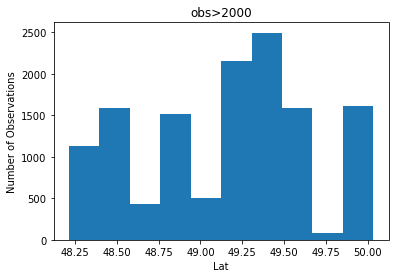

In [25]:
plt.hist(data.loc[data.PARRef>2000,['Lat']].values)
plt.xlabel('Lat')
plt.ylabel('Number of Observations')
plt.title('obs>2000');

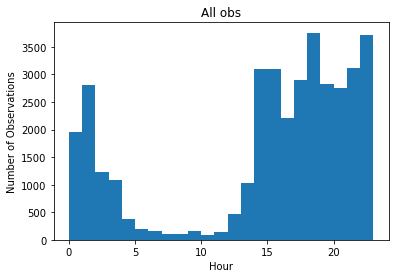

In [26]:
plt.hist(data['Hour'],np.arange(0,24))
plt.xlabel('Hour')
plt.ylabel('Number of Observations')
plt.title('All obs');

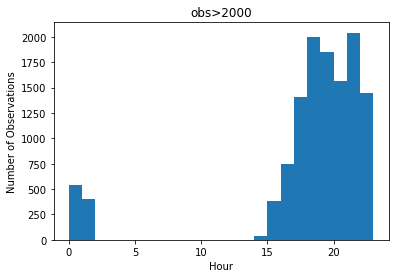

In [27]:
plt.hist(data.loc[data.PARRef>2000,['Hour']].values,np.arange(0,24))
plt.xlabel('Hour')
plt.ylabel('Number of Observations')
plt.title('obs>2000');

Text(0.5, 1.0, 'log10 Reference PAR Direct Comparison')

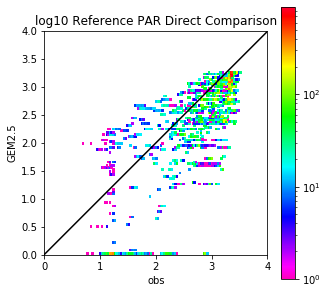

In [28]:
ii=(data['mod_solar']>=0)&(data['PARRef']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_solar']].values
xx=data.loc[ii,['PARRef']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('GEM2.5')
ax.set_title('log10 Reference PAR Direct Comparison')

Text(0.5, 0, 'Hour')

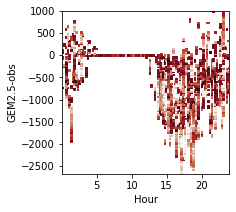

In [29]:
fig,ax=plt.subplots(1,1,figsize=(3,3))
ax.hist2d(data['Hour'],data['mod_solar']-data['PARRef'],
         bins=100,norm=mpl.colors.LogNorm(), cmap=cmocean.cm.amp,vmin=1,vmax=10**2);
ax.set_ylabel('GEM2.5-obs')
ax.set_xlabel('Hour')

In [30]:
stas=data.groupby(by=['Year','Month','Day','Lat','Lon'])

In [31]:
stas

In [32]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

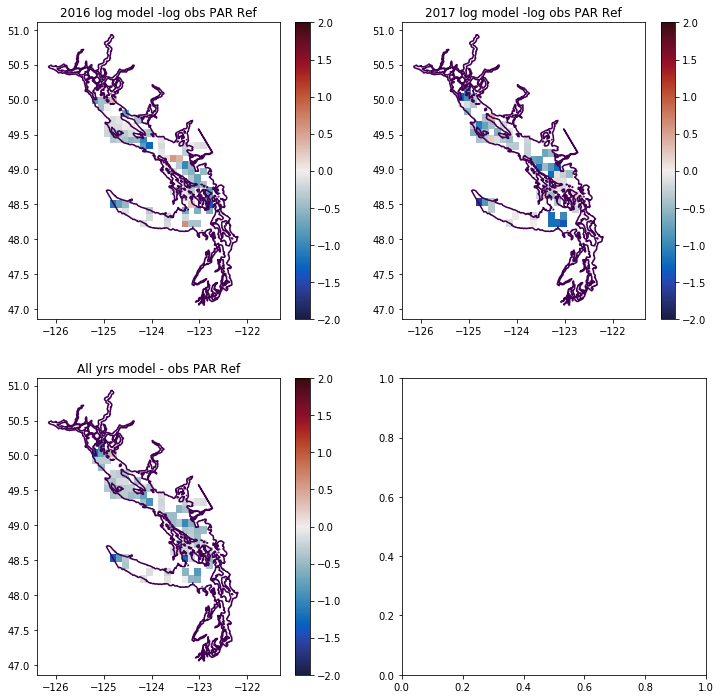

In [33]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2016,2018):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&(data['PARRef']>=0)&(data['mod_solar']>=0)]
    ax[yr-2016].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2016].set_title(str(yr)+' log model -log obs PAR Ref')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                np.log10(dyr['mod_solar']+1)-np.log10(dyr['PARRef']+1), 
                statistic='mean', bins=20)
    m=ax[yr-2016].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-2,vmax=2,shading='flat')
    plt.colorbar(m,ax=ax[yr-2016])
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&(data['PARRef']>=0)&(data['mod_solar']>=0)]
yr=yr+1
ax[yr-2016].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[yr-2016].set_title('All yrs model - obs PAR Ref')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           np.log10(dyr['mod_solar']+1)-np.log10(dyr['PARRef']+1), 
            statistic='mean', bins=20)
m=ax[yr-2016].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-2,vmax=2,shading='flat')
plt.colorbar(m,ax=ax[yr-2016])

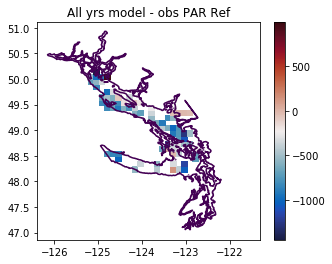

In [34]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&(data['PARRef']>=0)&(data['mod_solar']>=0)]
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax.set_title('All yrs model - obs PAR Ref')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           dyr['mod_solar']-dyr['PARRef'], 
            statistic='mean', bins=20)
m=ax.pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,shading='flat')
plt.colorbar(m,ax=ax)

Text(0, 0.5, 'Counts')

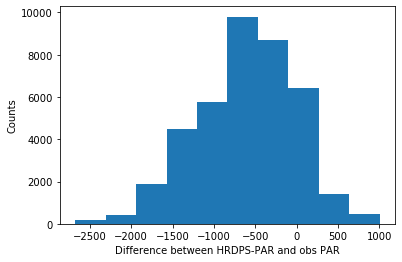

In [35]:
plt.hist(dyr['mod_solar']-dyr['PARRef'])
plt.xlabel('Difference between HRDPS-PAR and obs PAR')
plt.ylabel('Counts')

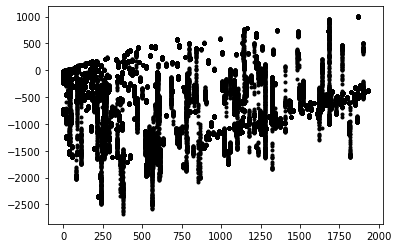

In [36]:
plt.plot(dyr['mod_solar'],dyr['mod_solar']-dyr['PARRef'],'k.')

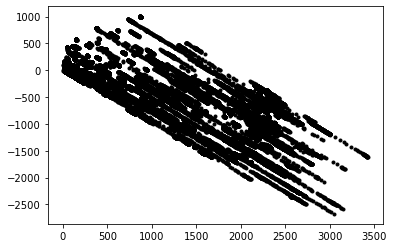

In [37]:
plt.plot(dyr['PARRef'],dyr['mod_solar']-dyr['PARRef'],'k.')

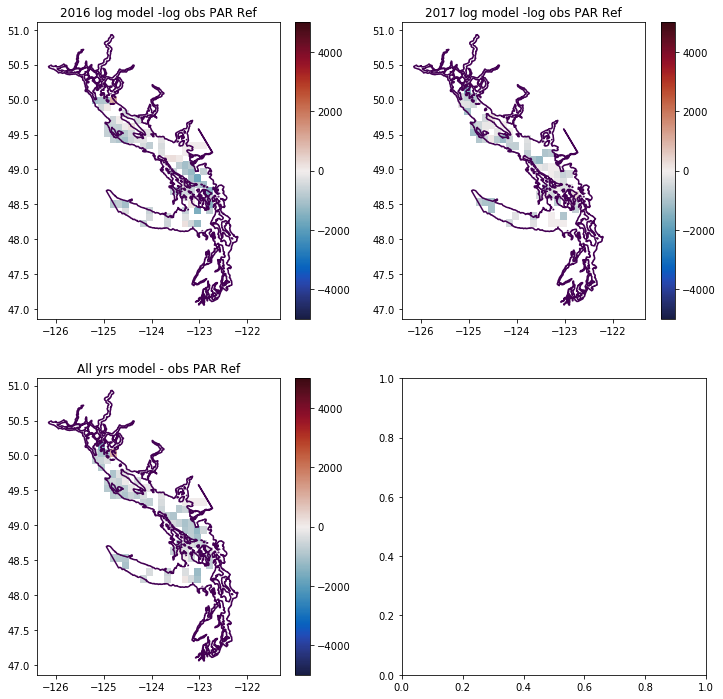

In [38]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2016,2018):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&(data['PARRef']>=0)&(data['mod_solar']>=0)]
    ax[yr-2016].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2016].set_title(str(yr)+' log model -log obs PAR Ref')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                dyr['mod_solar']-dyr['PARRef'], 
                statistic='mean', bins=20)
    m=ax[yr-2016].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5000,vmax=5000,shading='flat')
    plt.colorbar(m,ax=ax[yr-2016])
dyr=data.loc[(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&(data['PARRef']>=0)&(data['mod_solar']>=0)]
yr=yr+1
ax[yr-2016].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[yr-2016].set_title('All yrs model - obs PAR Ref')
s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
           dyr['mod_solar']-dyr['PARRef'], 
            statistic='mean', bins=20)
m=ax[yr-2016].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5000,vmax=5000,shading='flat')
plt.colorbar(m,ax=ax[yr-2016])